# Data Mining in Action, Deep Leaning

## Семантическая сегментация

В этом задании мы будем практиковаться в семантической сегментации. Реализуем популярную сеть для решения задачи семантической сегментации U-net, обучим её на синтетическом датасете с фигурами, оценим качество модели.

In [70]:
%pylab inline

import torch
import torchvision
from torch.utils.data import Dataset
from PIL import ImageDraw, Image

Populating the interactive namespace from numpy and matplotlib


E:\anaconda1\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['block', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Для создания моделей-сетей в `pytorch` удобно создавать класс, наследуясь от `torch.nn.Module`. В `torch.nn` содержася стандартные "кирпичики" для моделей (например, различные виды слоёв). В `torch.optim` содержатся оптимизаторы, а в `torch.utils.data` много необходимых сущеностей для работы с данными.

### Построение сети

Начнём с построения сети. Для сегментации будем использовать архитекрутуру U-net.

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Архитектура состоит из блоков (горизонтальные участки из синих прямоугольников). На примере выше сначала идёт 5 блоков кодировщика, далее 4 блока декодировщика. Между блоками кодировщика происходит уменьшение размерности в 2 раза с помощью max pooling. В декодировщике применяется upsampling и конкатенация с результатами соответствующего блока кодировщика. 

Давайте реализуем U-net по частям. Начнём с кодировщика. 

Один блок кодировщика состоит из двух последовательных сверток, активаций и батчнорма (опционально, но мы его сделаем дефолтным):

In [71]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu2 = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

In [72]:
block = EncoderBlock(3, 16)
block

EncoderBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
)

Запустим на картинке с 3 каналами размера 200 на 200 (первая "единичка" означает число картинок в батче).

In [73]:
block(torch.rand((1, 3, 200, 200))).size()

torch.Size([1, 16, 200, 200])

Получается, что размерность выхода при применении блока кодировщика не изменяется. Изменяется она только на max pooling и upsampling слоях.

Теперь составим кодировщик из описанных выше блоков. Конструкция определяется входными каналами, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации. Здесь как раз помогает подход к построению через `add_module`, так как количество блоков переменно.

In [74]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()
        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2**(i - 1)
            out_channels = num_filters * 2**i
            self.add_module(
                f"block{i + 1}", EncoderBlock(in_channels, out_channels)
            )
            if i != num_blocks - 1:
                self.add_module(f"pool{i + 1}", torch.nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f"block{i + 1}")(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f"pool{i + 1}")(x)
        return acts

Создадим кодировщик из 4 блоков, где базовая размерность будет 8.

In [75]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): EncoderBlock(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): EncoderBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blo

Проверьте, что на изображении 256 на 256 после каждого блока кодировщика размерность уменьшается в 2 раза, а число фильтров увеличивается в 2 раза, начиная с 8.

In [76]:
batch_X = torch.zeros(4, 3, 256, 256)

for x in encoder(batch_X):
    print(x.shape)

torch.Size([4, 8, 256, 256])
torch.Size([4, 16, 128, 128])
torch.Size([4, 32, 64, 64])
torch.Size([4, 64, 32, 32])


**Вопрос 1: Размерность последнего слоя энкодера**

Какая размерность на последнем слое (перемножьте все размерности включая размер батча). Внесите свой ответ в поле _"Вопрос 1: Размерность последнего слоя энкодера"_ гугл-формы этого домашнего задания.

Блок декодировщика состоит из апскейлинга входа "снизу", объединения двух входов и сверток как в кодировщике. Перед конкатенированием используем свёртку для уменьшения числа фильтров в 2 раза (их количество и так растёт в 2 раза в результате объединения).

In [77]:
np.prod([4, 64, 32, 32])
#262144

262144

In [78]:
def conv3x3(in_channels, out_channels, dilation=1):
    return torch.nn.Conv2d(
        in_channels, out_channels, 3, padding=dilation, dilation=dilation
    )

class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = torch.nn.Upsample(
            scale_factor=2, mode="bilinear", align_corners=True
        )
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


Проверим блок декодера, который отдаёт на выходе картинку толщиной в 8 фильтров.

In [79]:
block = DecoderBlock(8)

In [80]:
batch_inside = encoder(batch_X)
batch_inside[1].shape, batch_inside[0].shape

(torch.Size([4, 16, 128, 128]), torch.Size([4, 8, 256, 256]))

In [81]:
block(batch_inside[1], batch_inside[0]).shape

torch.Size([4, 8, 256, 256])

Декодировщик собираем из таких блоков:

In [82]:
class Decoder(torch.nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(
                f"block{num_blocks - i}", DecoderBlock(num_filters * 2**i)
            )

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f"block{i + 1}")(up, left)
        return up

In [83]:
decoder = Decoder(8, 3)

In [84]:
print(batch_X.shape)
print(decoder(encoder(batch_X)).shape)

torch.Size([4, 3, 256, 256])
torch.Size([4, 8, 256, 256])


U-Net состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [85]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=8, num_blocks=4):
        super().__init__()
        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = torch.nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [86]:
model = UNet(num_classes=6)

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

images = torch.randn(4, 3, 416, 416).to(device)
model(images).shape

torch.Size([4, 6, 416, 416])

In [88]:
np.prod([4, 6, 416, 416])
#4153344

4153344

**Вопрос 2: Размерность на выходе всей модели** 

Какая размерность получилась на выходе (перемножьте все размерности, включая количество батчей)? Внесите свой ответ в поле _"Вопрос 2:  Размерность на выходе всей модели"_ гугл-формы этого домашнего задания.

На выходе из сети получаем бинарную маску из линейных активаций. Для обучения такой модели используются функции потерь, которые включают в себя применение активации. В вероятности их можно превращать с помощью `torch.sigmoid`.

### Данные

Будем решать задачу семантической сегментации на синтетических данных, представляющий собой множество эллипсов, квадратов и треугольников с гауссовым шумом.

Для загрузки данных pytorch опирается на такую сущность, как `Dataset`. Этот абстрактный класс определен в `torch.utils.data.dataset`.

In [89]:
class Figures(Dataset):
    def __init__(self, num_images=10, num_figure=10, size_hor=200, size_ver=200,
                 min_size=5, max_size=40, noise=False,
                 normalize=None):
        
        self.images = []
        
        for _ in range(num_images):
            color_background = tuple(np.random.randint(low=0, high=255, size=3))
            image = Image.new(mode='RGB', size=(size_hor, size_ver), color=color_background)
            draw = ImageDraw.Draw(image)

            mask = Image.new(mode='1', size=(size_hor, size_ver), color=0)
            draw_mask = ImageDraw.Draw(mask)
            
            for i in range(num_figure):
                color = tuple(np.random.randint(low=0, high=255, size=3))
                size = np.random.randint(low=min_size, high=max_size)
                
                xl = np.random.randint(low=0, high=size_hor-size)
                yt = np.random.randint(low=0, high=size_ver-size)
                xr = xl + size
                yb = yt + size
                
                figure_type = np.random.choice(['circle', 'triangle', 'rectangle'])
                if figure_type == 'circle':
                    draw.ellipse((xl, yt, xr, yb), fill=color)
                    draw_mask.ellipse((xl, yt, xr, yb), fill=1)
                elif figure_type == 'rectangle':
                    draw.rectangle((xl, yt, xr, yb), fill=color)
                    draw_mask.rectangle((xl, yt, xr, yb), fill=1)
                elif figure_type == 'triangle':
                    draw.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=color)
                    draw_mask.polygon((xl, yb, xr, yb, (xl + xr) / 2, yt), fill=1)

            image = torchvision.transforms.ToTensor()(image).float()
            mask = torchvision.transforms.ToTensor()(mask).float()
            
            if normalize:
                image = normalize(image)
           
            if noise:
                mean, var = 0, 0.001
                gauss = np.random.normal(mean, var ** 0.5, (3, size_hor, size_ver))
                image = image + torch.FloatTensor(gauss)
                
            self.images.append({'image': image, 'mask': mask})

    def __getitem__(self, index):
        return self.images[index]
        
    def __len__(self):
        return len(self.images)

Примеры:

In [90]:
generator = Figures(noise=True, normalize=None)

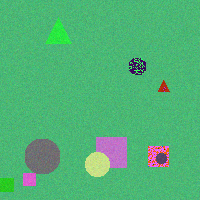

In [91]:
torchvision.transforms.ToPILImage()(generator[0]['image'])

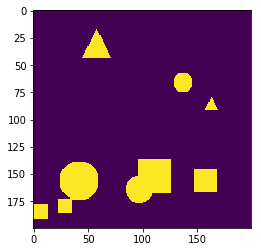

In [92]:
plt.imshow(np.array(generator[0]['mask'][0, :, :]).reshape((200, 200)))
plt.show()

Посчитаем среднее и дисперсию, чтобы дальше нормализовать с такими коэффициентами:

In [93]:
data = Figures(num_images=1000, noise=False)

image_pixels = torch.stack([ell['image'].reshape((3, -1)) for ell in data], dim=1)
mean_ = image_pixels.reshape((3, -1)).mean(1)
std_ = image_pixels.reshape((3, -1)).std(1)
normalize = torchvision.transforms.Normalize(mean_, std_)

### Обучение модели

Для оценки качества масок будем использовать Dice.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

При реализации не забывайте, что на вход поступает сразу весь батч, а результат должен быть усреднением dice-score по всем изображениям батча. Не забывайте о возможных численных неустойчивостях при возможности деления на ноль.

In [94]:
def dice_coefficient(mask, prediction):
    smooth = 0.000001
    num = prediction.size(0)
    m1 = prediction.view(num, -1)  # Flatten
    m2 = mask.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

Проверим реализацию dice.

In [95]:
torch.manual_seed(10)

test_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()
prediction_mask = torch.randint(0, 2, size=(8, 1, 300, 300)).float()

dice_coefficient(test_mask, prediction_mask)

tensor(0.5005)

In [96]:
#0.5005

**Вопрос 3: Dice Coefficient**

Какой результат получился в клетке выше (ответ округлите до **четырех** знаков после запятой, например: 0.6576)? Внесите свой ответ в поле _"Вопрос 3: Dice Coefficient"_ гугл-формы этого домашнего задания.

Подготовим обучающую и тестовую выборки.

In [97]:
batch_size = 8

train_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=500),
    batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=200),
    batch_size=batch_size)

train_size = len(train_data_loader.dataset)
test_size = len(test_data_loader.dataset)

Для обучения моделей необходимо определить функцию потерь, их примеры содержатся в модуле `torch.nn`. Сейчас для задачи бинарной сегментации нам потребуется бинарная кросс энтропия, которая на вход будет принимать не вероятности, а сырые значения (у нас сеть заканчивается линейным слоем). Найдите такую функцию.

In [98]:
sigmoid = torch.nn.Sigmoid()
criterion =  torch.nn.BCEWithLogitsLoss()
num_epoch = 10

network = UNet(num_classes=1)
optimizer = torch.optim.Adam(network.parameters())

In [99]:
global_step = 0

for epoch in range(num_epoch):
    loss_train = 0
    for i, batch in enumerate(train_data_loader):
        # main train loop: zero gradient, forward, loss, backward, update
        optimizer.zero_grad()
        output = network(batch['image'])
        loss = criterion(output, batch['mask'])
        loss_train += batch_size * float(loss.detach())
        loss.backward()
        optimizer.step()
    loss_train = loss_train / train_size
        
    loss_test, dice_test = 0, 0
    for i, batch in enumerate(test_data_loader):
        output = network(batch['image'])
        prediction_mask = (output > 0).float()
        loss_test += batch_size * float(criterion(output, batch['mask']).detach())
        dice_test += batch_size * float(dice_coefficient(batch['mask'], prediction_mask).detach())
    loss_test = loss_test / test_size
    dice_test = dice_test / test_size
    
    print('epoch: {},\ttrain loss: {},\ttest loss: {},\ttest dice: {}'.format(
        epoch, round(loss_train, 5), round(loss_test, 5), round(dice_test, 5)))

epoch: 0,	train loss: 0.26532,	test loss: 0.1723,	test dice: 0.66487
epoch: 1,	train loss: 0.13343,	test loss: 0.11904,	test dice: 0.7432
epoch: 2,	train loss: 0.08521,	test loss: 0.08295,	test dice: 0.8474
epoch: 3,	train loss: 0.07608,	test loss: 0.07174,	test dice: 0.86682
epoch: 4,	train loss: 0.06526,	test loss: 0.05789,	test dice: 0.88885
epoch: 5,	train loss: 0.05448,	test loss: 0.05104,	test dice: 0.90046
epoch: 6,	train loss: 0.04644,	test loss: 0.04568,	test dice: 0.91442
epoch: 7,	train loss: 0.04349,	test loss: 0.04233,	test dice: 0.91949
epoch: 8,	train loss: 0.03937,	test loss: 0.04254,	test dice: 0.9227
epoch: 9,	train loss: 0.03689,	test loss: 0.04321,	test dice: 0.92226


In [100]:
#0.04

**Вопрос 4: Функция потерь на тестовой выборке**

Какое значение функции потерь получилось после 10 эпох на тестовой выборке (ответ округлите до **двух** знаков после запятой, например: 0.65)? Внесите свой ответ в поле _"Вопрос 4: Функция потерь на тестовой выборке"_ гугл-формы этого домашнего задания.

Визуализируйте 3 произвольных картинки, их маски и предсказания сети.

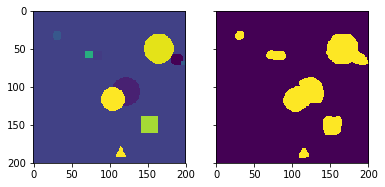

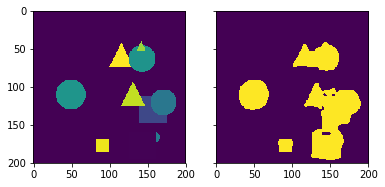

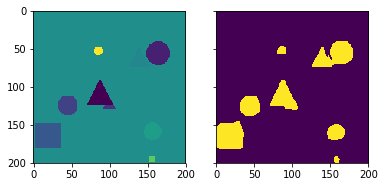

In [101]:
for h in (np.random.randint(8, size = 3)):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(batch['image'][h][0, :, :].reshape((200, 200)))
    ax2.imshow(np.array(prediction_mask)[h][0, :, :].reshape((200, 200)))
    plt.show()

Попробуйте увеличить `batch_size` в 4 раза и повторите обучение с теми же 10 эпохами.

In [102]:
batch_size = 8 * 4

train_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=1000),
    batch_size=batch_size, shuffle=True)

test_data_loader = torch.utils.data.DataLoader(
    dataset=Figures(noise=False, normalize=normalize, num_images=250),
    batch_size=batch_size)

test_size = len(test_data_loader.dataset)

In [103]:
criterion = torch.nn.BCEWithLogitsLoss()
num_epoch = 10

network = UNet(num_classes=1)
optimizer = torch.optim.Adam(network.parameters())

In [104]:
global_step = 0

for epoch in range(num_epoch):
    loss_train = 0
    for i, batch in enumerate(train_data_loader):
        # main train loop: zero gradient, forward, loss, backward, update
        optimizer.zero_grad()
        output = network(batch['image'])
        loss = criterion(output, batch['mask'])
        loss_train += batch_size * float(loss.detach())
        loss.backward()
        optimizer.step()
    loss_train = loss_train / train_size
        
    loss_test, dice_test = 0, 0
    for i, batch in enumerate(test_data_loader):
        output = network(batch['image'])
        prediction_mask = (output > 0).float()
        loss_test += batch_size * float(criterion(output, batch['mask']).detach())
        dice_test += batch_size * float(dice_coefficient(batch['mask'], prediction_mask).detach())
    loss_test = loss_test / test_size
    dice_test = dice_test / test_size
    
    print('epoch: {},\ttrain loss: {},\ttest loss: {},\ttest dice: {}'.format(
        epoch, round(loss_train, 5), round(loss_test, 5), round(dice_test, 5)))

epoch: 0,	train loss: 0.67961,	test loss: 0.20124,	test dice: 0.6037
epoch: 1,	train loss: 0.31961,	test loss: 0.13746,	test dice: 0.77474
epoch: 2,	train loss: 0.21945,	test loss: 0.09377,	test dice: 0.84457
epoch: 3,	train loss: 0.16222,	test loss: 0.07664,	test dice: 0.88323
epoch: 4,	train loss: 0.13482,	test loss: 0.06375,	test dice: 0.90473
epoch: 5,	train loss: 0.11614,	test loss: 0.05586,	test dice: 0.91805
epoch: 6,	train loss: 0.10502,	test loss: 0.11443,	test dice: 0.83498
epoch: 7,	train loss: 0.15144,	test loss: 0.05655,	test dice: 0.91823
epoch: 8,	train loss: 0.10142,	test loss: 0.04723,	test dice: 0.93525
epoch: 9,	train loss: 0.0866,	test loss: 0.04306,	test dice: 0.94178


**Вопрос 5: Dice Coefficient на тестовой выборке**

Какое значение dice на тестовой выборке после 10 эпох (ответ округлите до **двух** знаков после запятой, например: 0.65)? Внесите свой ответ в поле _"Вопрос 5: Dice Coefficient на тестовой выборке"_ гугл-формы этого домашнего задания.

In [105]:
#0.94

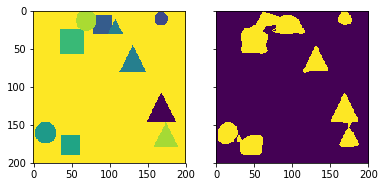

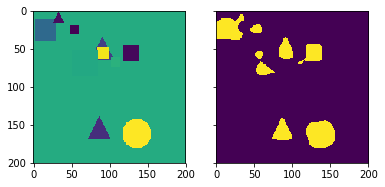

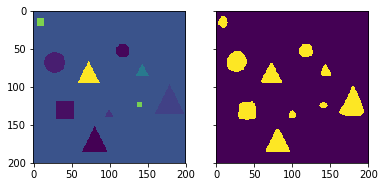

In [108]:
for h in (np.random.randint(8 * 3, size = 3)):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(batch['image'][h][0, :, :].reshape((200, 200)))
    ax2.imshow(np.array(prediction_mask)[h][0, :, :].reshape((200, 200)))
    plt.show()